In [1]:
# instalando dependências e criando pastas
!pip install -q "tensorflow>=2.10" tensorflow-datasets scikit-learn matplotlib seaborn streamlit gradio

import os
os.makedirs("/content/garbage-nn/src", exist_ok=True)
os.makedirs("/content/garbage-nn/notebooks", exist_ok=True)
os.makedirs("/content/garbage-nn/data", exist_ok=True)

print("Diretórios criados em /content/garbage-nn")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.2 MB/s eta 0:00:00
Diretórios criados em /content/garbage-nn


In [2]:
import os
from google.colab import files

# 1. Instala a biblioteca do Kaggle
!pip install -q kaggle

# 2. Solicita o upload do arquivo kaggle.json
print("Por favor, faça o upload do seu arquivo 'kaggle.json'")
uploaded = files.upload()

# Verifica se o upload foi bem-sucedido e renomeia o arquivo para 'kaggle.json'
if not uploaded:
    print("\nNenhum arquivo foi enviado. Por favor, execute a célula novamente.")
else:
    # Pega o nome do arquivo que foi enviado
    original_filename = next(iter(uploaded))

    # Renomeia o arquivo para o nome padrão 'kaggle.json'
    os.rename(original_filename, 'kaggle.json')
    print(f"\nArquivo '{original_filename}' salvo como 'kaggle.json'.")

    # 3. Configura o token para autenticação
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # 4. Baixa o dataset do Kaggle
    DATASET_ID = "mostafaabla/garbage-classification"
    !kaggle datasets download -d {DATASET_ID} -p /content/

    # 5. Descompacta, move para a pasta do projeto e limpa os arquivos temporários
    ZIP_FILE = DATASET_ID.split('/')[1] + ".zip"
    !unzip -q /content/{ZIP_FILE} -d /content/temp_dataset
    !mv /content/temp_dataset/garbage_classification/* /content/garbage-nn/
    !rm -rf /content/temp_dataset /content/{ZIP_FILE} kaggle.json

    print("\nDataset do Kaggle pronto para ser usado em /content/garbage-nn/")

Por favor, faça o upload do seu arquivo 'kaggle.json'


Saving kaggle (1).json to kaggle (1).json

Arquivo 'kaggle (1).json' salvo como 'kaggle.json'.
Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 61% 147M/239M [00:00<00:00, 1.54GB/s]
100% 239M/239M [00:00<00:00, 929MB/s] 

Dataset do Kaggle pronto para ser usado em /content/garbage-nn/


In [3]:
# Definindo padrâmetros
EPOCHS = 30
BATCH_SIZE = 64
IMG_SIZE = (128,128)
SEEDS = [42, 43, 44]
DATA_DIR = "/content/garbage-nn"
print("EPOCHS =", EPOCHS)

EPOCHS = 30


In [4]:
# imports e preprocessamento
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from pathlib import Path
import shutil

AUTOTUNE = tf.data.AUTOTUNE

def scale_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def central_crop_and_resize(image, label, img_size=IMG_SIZE, central_fraction = 0.7):
    image = tf.image.central_crop(image, central_fraction=central_fraction)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def resize_only(image, label, img_size = IMG_SIZE):
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
import shutil
from pathlib import Path

orig_dir = Path("/content/garbage-nn")
DATA_DIR = Path("/content/garbage-nn/data")
train_dir = DATA_DIR / "train"
test_dir = DATA_DIR / "test"

if DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

project_folders = ['src', 'notebooks', 'data', 'figures']
class_names_from_folders = [d.name for d in orig_dir.iterdir() if d.is_dir() and d.name not in project_folders]
print(f"Classes de lixo encontradas para organizar: {class_names_from_folders}")

test_split = 0.2
np.random.seed(SEEDS[0])

for class_name in class_names_from_folders:
    class_path = orig_dir / class_name
    images = list(class_path.glob("*.[jp][pn]g")) + list(class_path.glob("*.jpeg"))
    np.random.shuffle(images)
    split_idx = int(len(images) * (1 - test_split))
    train_imgs = images[:split_idx]
    test_imgs = images[split_idx:]
    (train_dir / class_name).mkdir(exist_ok=True)
    (test_dir / class_name).mkdir(exist_ok=True)
    for img in train_imgs:
        shutil.copy(img, train_dir / class_name / img.name)
    for img in test_imgs:
        shutil.copy(img, test_dir / class_name / img.name)

print("\nPastas train/ e test/ criadas corretamente em", DATA_DIR)

Classes de lixo encontradas para organizar: ['plastic', 'brown-glass', 'white-glass', 'shoes', 'battery', 'green-glass', 'biological', 'cardboard', 'clothes', 'metal', 'trash', 'paper']

Pastas train/ e test/ criadas corretamente em /content/garbage-nn/data


In [6]:
# Carregando e otimizando os datasets
train_dir = "/content/garbage-nn/data/train"
test_dir = "/content/garbage-nn/data/test"

# Carrega o dataset base antes do .map() para pegar os nomes das classes
train_ds_base = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
class_names = train_ds_base.class_names
num_classes = len(class_names)

# Otimização: tf.data.AUTOTUNE encontra o melhor valor dinamicamente
AUTOTUNE = tf.data.AUTOTUNE

# Agora aplica o .map() e as otimizações
train_ds_resize = train_ds_base.map(scale_images).cache().prefetch(buffer_size=AUTOTUNE)

test_ds_resize = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(scale_images).cache().prefetch(buffer_size=AUTOTUNE)

train_ds_crop = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
).map(lambda x, y: central_crop_and_resize(x, y, img_size=IMG_SIZE)).map(scale_images).cache().prefetch(buffer_size=AUTOTUNE)

test_ds_crop = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(lambda x, y: central_crop_and_resize(x, y, img_size=IMG_SIZE)).map(scale_images).cache().prefetch(buffer_size=AUTOTUNE)

print(f"Classes encontradas: {class_names}")
print(f"Número de classes: {num_classes}")
print("\nTodos os datasets foram criados e OTIMIZADOS com sucesso!")

Found 12409 files belonging to 12 classes.
Found 3106 files belonging to 12 classes.
Found 12409 files belonging to 12 classes.
Found 3106 files belonging to 12 classes.
Classes encontradas: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Número de classes: 12

Todos os datasets foram criados e OTIMIZADOS com sucesso!


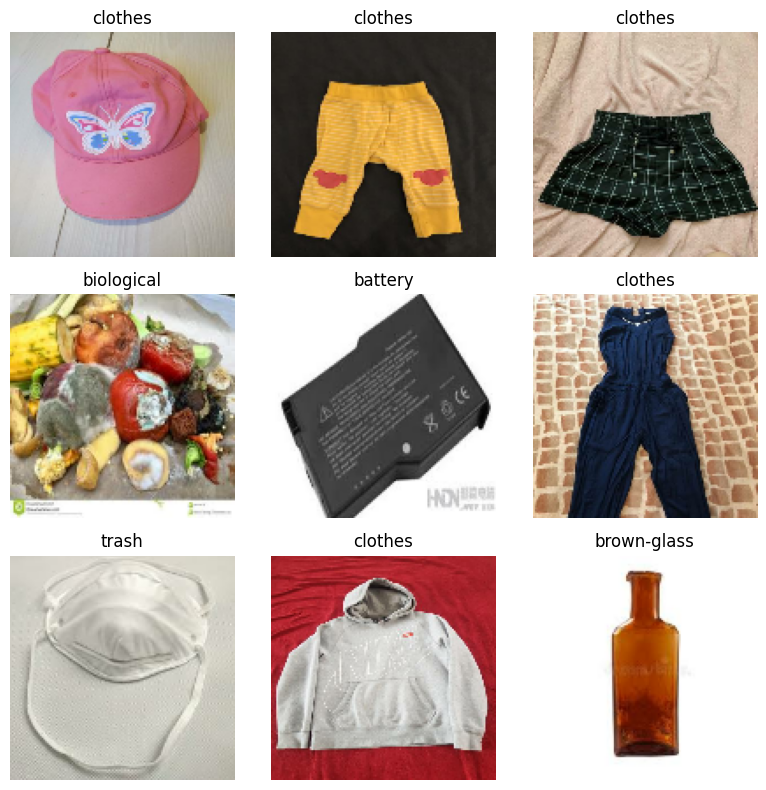

In [7]:
# Visualização de exemplos do dataset
import matplotlib.pyplot as plt
import os

def plot_dataset_examples(dataset, class_names, n=9, save_path="figures/dataset_examples.png"):
    plt.figure(figsize=(8, 8))

    # Pega um único lote (batch) do dataset
    for images, labels in dataset.take(1):
        # Itera sobre as imagens e rótulos dentro do lote
        for i in range(n):
            ax = plt.subplot(3, 3, i + 1)
            # Seleciona a i-ésima imagem e a normaliza para visualização
            plt.imshow((images[i].numpy() * 255).astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")

    plt.tight_layout()

    # Garante que o diretório 'figures' exista
    os.makedirs("figures", exist_ok=True)
    plt.savefig(save_path)
    plt.show()

# Chama a função
plot_dataset_examples(train_ds_resize, class_names)

In [10]:
from tensorflow.keras import layers, regularizers, Model, Input

# Define um tamanho de imagem PEQUENO especificamente para o MLP
IMG_SIZE_MLP = (48, 48)

def build_mlp(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = layers.Flatten()(inputs)

    # Camadas DENSAS MENORES para ficarem dentro do limite
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs, name="mlp")
    params = model.count_params()
    assert params <= 1_000_000, f"MLP tem {params:,} parâmetros (>1M)"
    return model

def build_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs, name="cnn")
    params = model.count_params()
    assert params <= 1_000_000, f"CNN tem {params:,} parâmetros (>1M)"
    return model

# Define os tamanhos de entrada para cada modelo
_input_shape_cnn = (IMG_SIZE[0], IMG_SIZE[1], 3) # Ex: (128, 128, 3)
_input_shape_mlp = (IMG_SIZE_MLP[0], IMG_SIZE_MLP[1], 3) # Ex: (48, 48, 3)

print("--- Verificação Final dos Parâmetros ---")
mlp_model = build_mlp(_input_shape_mlp, num_classes)
print(f"MLP params: {mlp_model.count_params():,} (Limite: 1,000,000)")

cnn_model = build_cnn(_input_shape_cnn, num_classes)
print(f"CNN params: {cnn_model.count_params():,} (Limite: 1,000,000)")

--- Verificação Final dos Parâmetros ---
MLP params: 893,900 (Limite: 1,000,000)
CNN params: 111,308 (Limite: 1,000,000)


In [9]:
# função de treino e avaliação
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os


def train_and_evaluate(model_name, preprocess, seed, epochs, class_names, train_ds, test_ds):

    tf.random.set_seed(seed)

    # Selecionar o modelo
    if model_name == "mlp":
        img_shape = (IMG_SIZE_MLP[0], IMG_SIZE_MLP[1], 3)
        model = build_mlp(img_shape, num_classes)
    elif model_name == "cnn":
        img_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
        model = build_cnn(img_shape, num_classes)
    else:
        raise ValueError("model_name deve ser 'mlp' ou 'cnn'")

    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=test_ds,
                        verbose=0)

    # Avaliação
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = np.argmax(model.predict(test_ds), axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f"Resultados para {model_name} + {preprocess} (seed {seed}):")
    print(f"Acurácia: {acc:.4f}")
    print(f"F1-score (macro): {f1:.4f}")

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name} + {preprocess} (seed {seed})')
    fig_path = f"figures/cm_{model_name}_{preprocess}_seed{seed}.png"
    os.makedirs("figures", exist_ok=True)
    plt.savefig(fig_path)
    plt.show()

    results = {
        'model': model_name,
        'preprocess': preprocess,
        'seed': seed,
        'test_accuracy': acc,
        'f1_macro': f1,
        'history': history.history,
        'model_object': model
    }

    return history.history, acc, f1, results

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Resultados para cnn + resize (seed 42):
Acurácia: 0.7292
F1-score (macro): 0.6707
              precision    recall  f1-score   support

     battery       0.77      0.59      0.66       189
  biological       0.75      0.78      0.76       197
 brown-glass       0.72      0.71      0.72       122
   cardboard       0.73      0.78      0.75       179
     clothes       0.83      0.91      0.87      1065
 green-glass       0.81      0.94      0.87       126
       metal       0.43      0.45      0.44       154
       paper       0.68      0.75      0.72       210
     plastic       0.59      0.49      0.53       173
       shoes       0.61      0.58      0.59       396
       trash       0.71      0.51      0.60       140
 white-glass       0.63      0.46      0.53       155

    accuracy                           0.73      3106
   macro avg       0.69      0.66      0.67      3106
weighted avg       0.72      0.73      0.72      3106



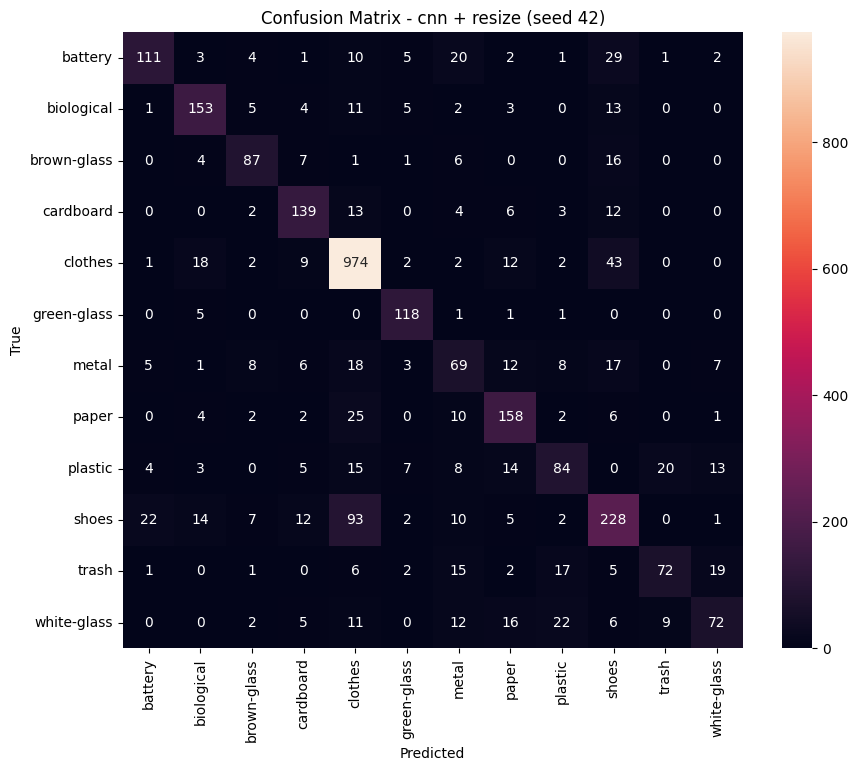

({'accuracy': [0.38101378083229065, 0.4978644549846649, 0.5360625386238098, 0.5602385401725769, 0.574985921382904, 0.5898138284683228, 0.5973889827728271, 0.6062535047531128, 0.6169715523719788, 0.6185832619667053, 0.6301877498626709, 0.6361511945724487, 0.6417922377586365, 0.6479974389076233, 0.6550890207290649, 0.6521073579788208, 0.6605689525604248, 0.6647594571113586, 0.6685470342636108, 0.6740269064903259, 0.6798291802406311, 0.6844226121902466, 0.6888548731803894, 0.6878072619438171, 0.6935288906097412, 0.699975848197937, 0.7022322416305542, 0.7055363059043884, 0.7102909088134766, 0.7081151008605957], 'loss': [1.9788182973861694, 1.575862169265747, 1.4349838495254517, 1.3435126543045044, 1.297592282295227, 1.2680246829986572, 1.2344846725463867, 1.2028720378875732, 1.1748071908950806, 1.1562494039535522, 1.1326665878295898, 1.1068394184112549, 1.0916939973831177, 1.0794564485549927, 1.0611494779586792, 1.0506045818328857, 1.0375661849975586, 1.0179299116134644, 1.010304570198059,

In [11]:
# experimento 1 - (CNN + resize, seed 42)
res = train_and_evaluate(
    model_name="cnn",
    preprocess="resize",
    seed=SEEDS[0],
    epochs=EPOCHS,
    class_names=class_names,
    train_ds=train_ds_resize,
    test_ds=test_ds_resize
)
print(res)

In [12]:
import tensorflow as tf
import os


train_ds_mlp = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE_MLP,
    batch_size=BATCH_SIZE,
).map(scale_images).cache().prefetch(buffer_size=AUTOTUNE)

test_ds_mlp = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE_MLP,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(scale_images).cache().prefetch(buffer_size=AUTOTUNE)

Found 12409 files belonging to 12 classes.
Found 3106 files belonging to 12 classes.


--- INICIANDO BATERIA COMPLETA DE EXPERIMENTOS ---
PULANDO: Modelo=cnn, Pré-processamento=resize, Seed=42 (já executado)

TREINANDO: Modelo=cnn, Pré-processamento=resize, Seed=43
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Resultados para cnn + resize (seed 43):
Acurácia: 0.7312
F1-score (macro): 0.6719
              precision    recall  f1-score   support

     battery       0.72      0.60      0.65       189
  biological       0.70      0.79      0.74       197
 brown-glass       0.62      0.80      0.70       122
   cardboard       0.83      0.72      0.77       179
     clothes       0.83      0.93      0.88      1065
 green-glass       0.82      0.90      0.86       126
       metal       0.51      0.44      0.47       154
       paper       0.71      0.70      0.70       210
     plastic       0.60      0.45      0.51       173
       shoes       0.59      0.55      0.57       396
       trash       0.64      0.64      0.64       140
 white-glass       0.70      0.48      0.57       

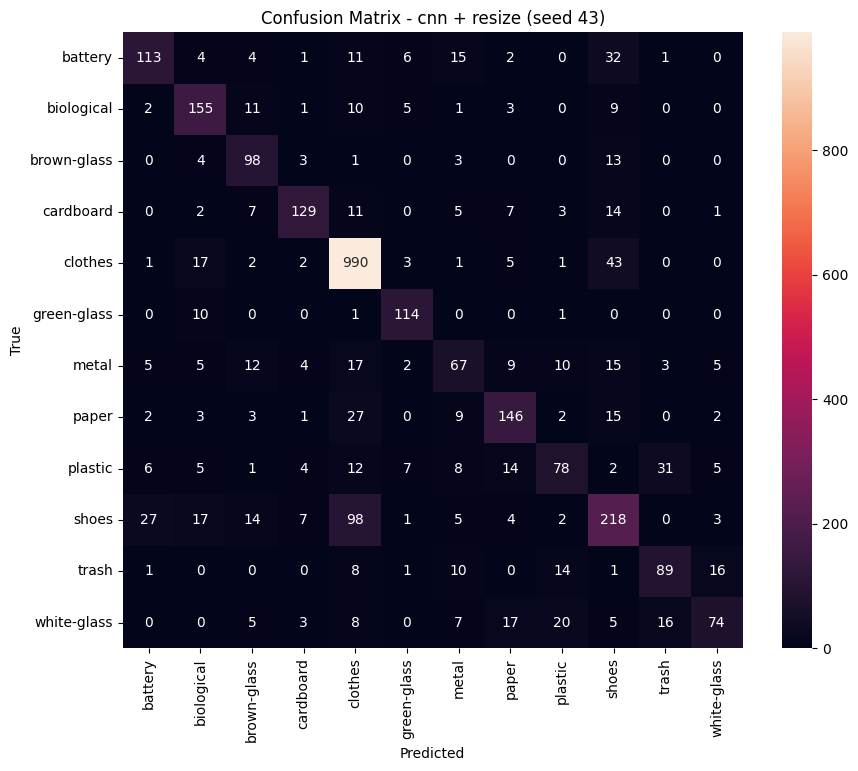


TREINANDO: Modelo=cnn, Pré-processamento=resize, Seed=44
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Resultados para cnn + resize (seed 44):
Acurácia: 0.7434
F1-score (macro): 0.6848
              precision    recall  f1-score   support

     battery       0.74      0.60      0.66       189
  biological       0.75      0.82      0.79       197
 brown-glass       0.70      0.80      0.75       122
   cardboard       0.79      0.83      0.81       179
     clothes       0.87      0.90      0.89      1065
 green-glass       0.81      0.98      0.88       126
       metal       0.54      0.38      0.45       154
       paper       0.66      0.78      0.72       210
     plastic       0.64      0.45      0.53       173
       shoes       0.57      0.62      0.59       396
       trash       0.62      0.64      0.63       140
 white-glass       0.66      0.44      0.53       155

    accuracy                           0.74      3106
   macro avg       0.70      0.69      0.68      3106
weighted

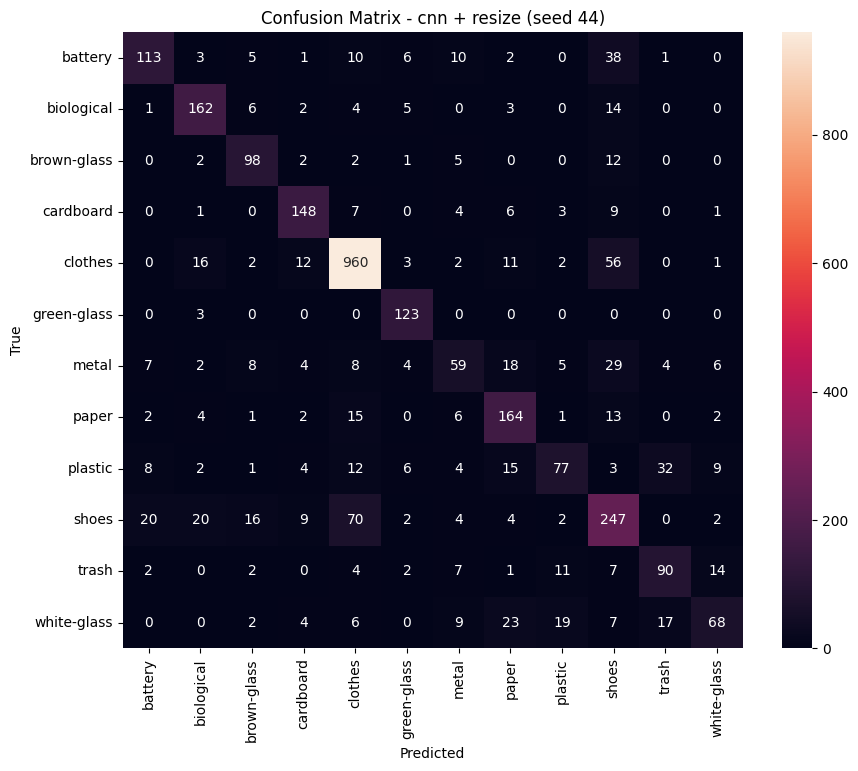


TREINANDO: Modelo=cnn, Pré-processamento=crop, Seed=42
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Resultados para cnn + crop (seed 42):
Acurácia: 0.4559
F1-score (macro): 0.2424
              precision    recall  f1-score   support

     battery       0.61      0.32      0.42       189
  biological       0.33      0.02      0.03       197
 brown-glass       0.47      0.22      0.30       122
   cardboard       0.55      0.09      0.15       179
     clothes       0.49      0.99      0.66      1065
 green-glass       0.35      0.13      0.20       126
       metal       0.23      0.02      0.04       154
       paper       0.30      0.15      0.20       210
     plastic       0.28      0.11      0.16       173
       shoes       0.42      0.33      0.37       396
       trash       0.29      0.34      0.31       140
 white-glass       0.16      0.06      0.09       155

    accuracy                           0.46      3106
   macro avg       0.37      0.23      0.24      3106
weighted avg

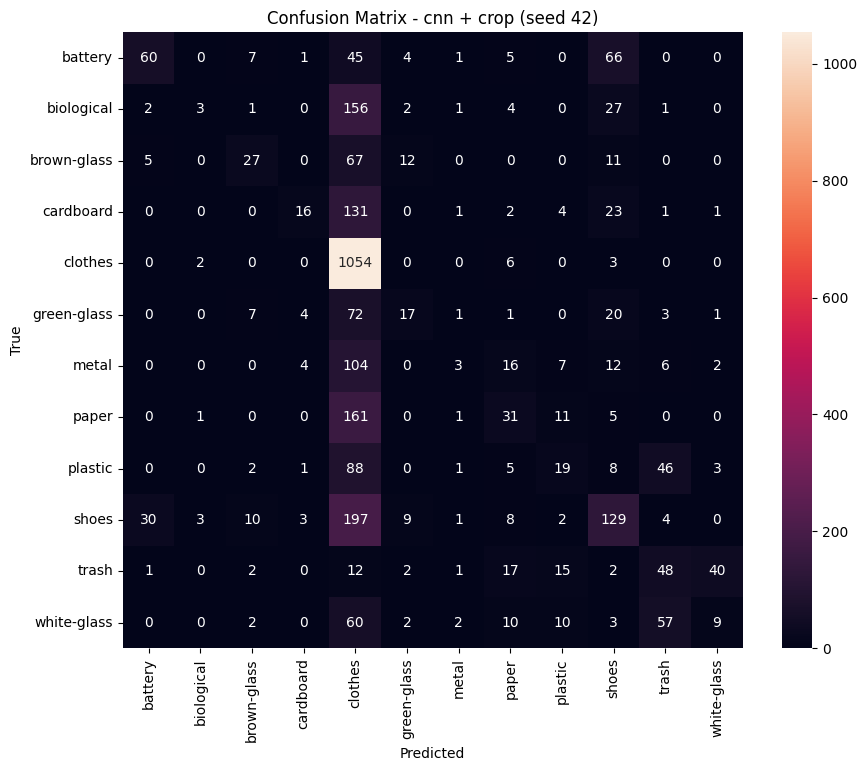


TREINANDO: Modelo=cnn, Pré-processamento=crop, Seed=43
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Resultados para cnn + crop (seed 43):
Acurácia: 0.4762
F1-score (macro): 0.2820
              precision    recall  f1-score   support

     battery       0.60      0.32      0.42       189
  biological       0.50      0.01      0.02       197
 brown-glass       0.45      0.32      0.37       122
   cardboard       0.50      0.05      0.09       179
     clothes       0.52      0.99      0.68      1065
 green-glass       0.40      0.11      0.17       126
       metal       0.37      0.10      0.15       154
       paper       0.37      0.16      0.23       210
     plastic       0.29      0.23      0.25       173
       shoes       0.37      0.33      0.35       396
       trash       0.37      0.34      0.35       140
 white-glass       0.37      0.24      0.29       155

    accuracy                           0.48      3106
   macro avg       0.43      0.27      0.28      3106
weighted avg

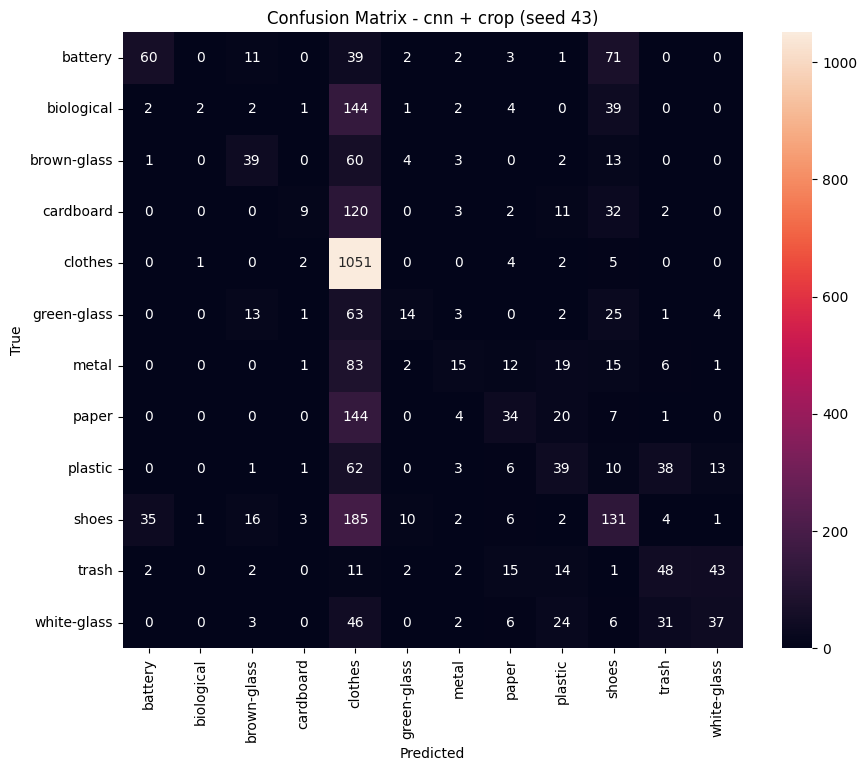


TREINANDO: Modelo=cnn, Pré-processamento=crop, Seed=44
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Resultados para cnn + crop (seed 44):
Acurácia: 0.4565
F1-score (macro): 0.2356
              precision    recall  f1-score   support

     battery       0.56      0.34      0.42       189
  biological       0.00      0.00      0.00       197
 brown-glass       0.49      0.22      0.31       122
   cardboard       0.50      0.06      0.10       179
     clothes       0.49      0.99      0.65      1065
 green-glass       0.42      0.11      0.18       126
       metal       0.20      0.05      0.07       154
       paper       0.34      0.16      0.22       210
     plastic       0.25      0.05      0.09       173
       shoes       0.38      0.32      0.35       396
       trash       0.36      0.54      0.43       140
 white-glass       0.05      0.01      0.01       155

    accuracy                           0.46      3106
   macro avg       0.34      0.24      0.24      3106
weighted avg

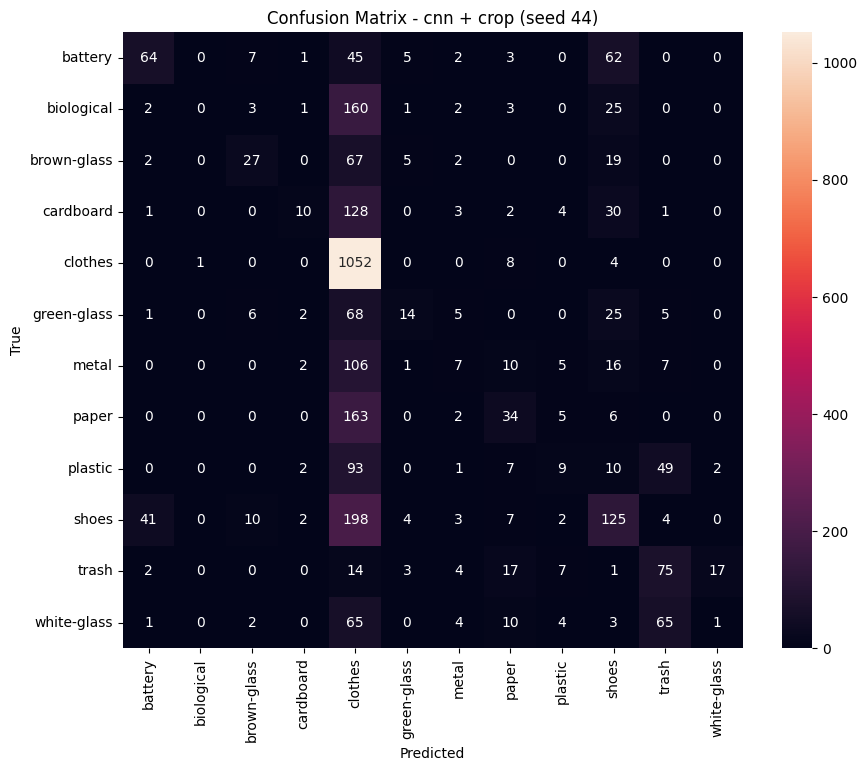


TREINANDO: Modelo=mlp, Pré-processamento=resize, Seed=42
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Resultados para mlp + resize (seed 42):
Acurácia: 0.4495
F1-score (macro): 0.2372
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       189
  biological       0.43      0.46      0.44       197
 brown-glass       0.00      0.00      0.00       122
   cardboard       0.24      0.11      0.15       179
     clothes       0.75      0.85      0.80      1065
 green-glass       0.23      0.79      0.36       126
       metal       0.00      0.00      0.00       154
       paper       0.19      0.42      0.26       210
     plastic       0.00      0.00      0.00       173
       shoes       0.22      0.27      0.24       396
       trash       0.51      0.14      0.21       140
 white-glass       0.35      0.41      0.38       155

    accuracy                           0.45      3106
   macro avg       0.24      0.29      0.24      3106
weighted 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


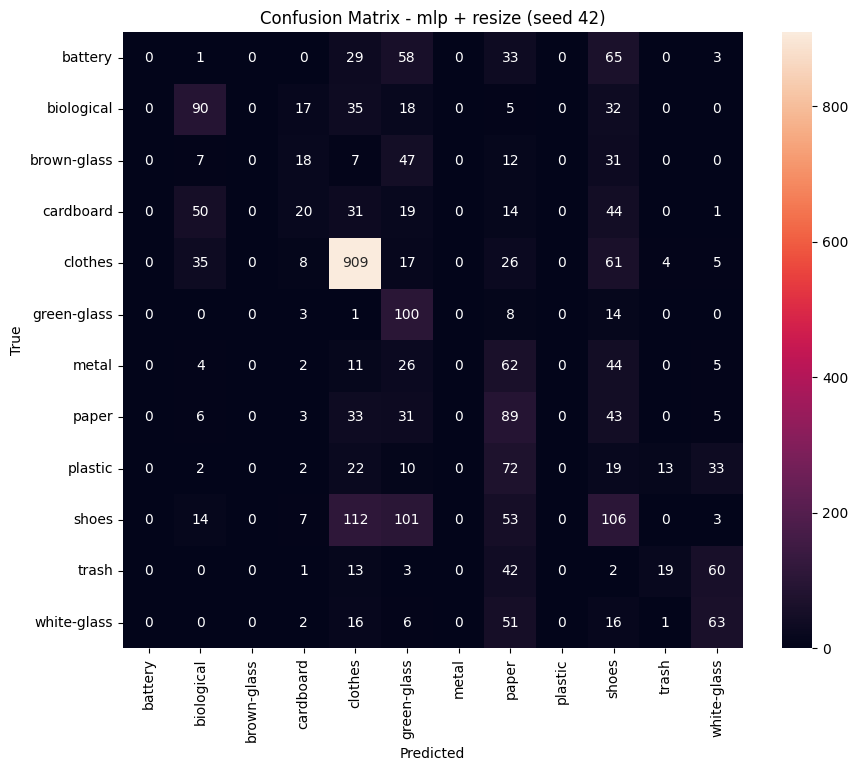


TREINANDO: Modelo=mlp, Pré-processamento=resize, Seed=43
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultados para mlp + resize (seed 43):
Acurácia: 0.4462
F1-score (macro): 0.2092
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       189
  biological       0.43      0.46      0.45       197
 brown-glass       0.00      0.00      0.00       122
   cardboard       0.32      0.20      0.24       179
     clothes       0.59      0.90      0.71      1065
 green-glass       0.34      0.71      0.46       126
       metal       0.00      0.00      0.00       154
       paper       0.13      0.10      0.12       210
     plastic       0.00      0.00      0.00       173
       shoes       0.28      0.39      0.33       396
       trash       0.00      0.00      0.00       140
 white-glass       0.19      0.22      0.21       155

    accuracy                           0.45      3106
   macro avg       0.19      0.25      0.21      3106
weighted 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


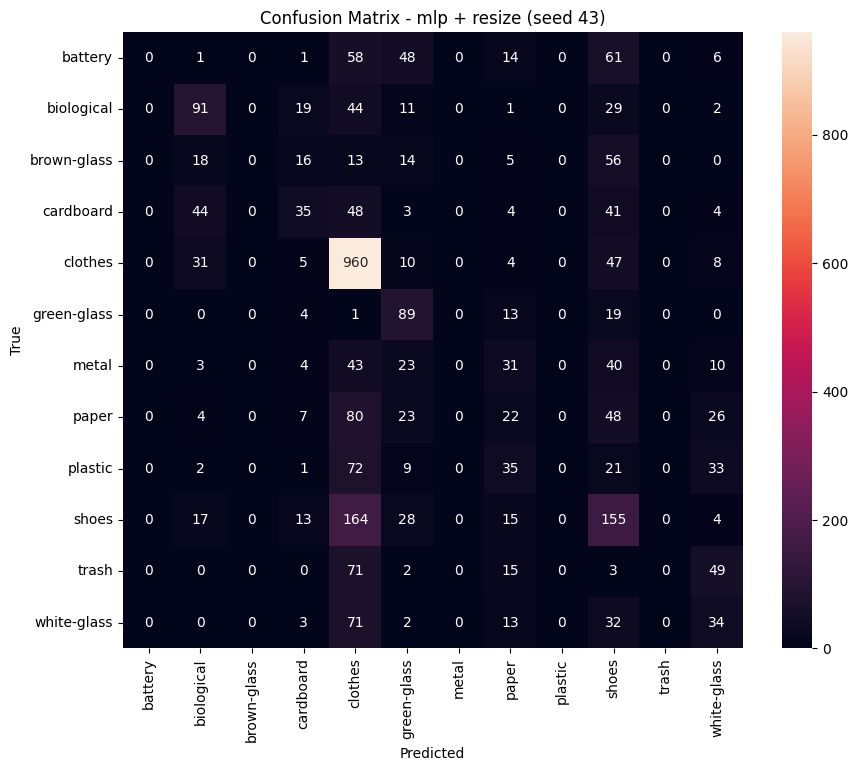


TREINANDO: Modelo=mlp, Pré-processamento=resize, Seed=44
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultados para mlp + resize (seed 44):
Acurácia: 0.3429
F1-score (macro): 0.0426
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       189
  biological       0.00      0.00      0.00       197
 brown-glass       0.00      0.00      0.00       122
   cardboard       0.00      0.00      0.00       179
     clothes       0.34      1.00      0.51      1065
 green-glass       0.00      0.00      0.00       126
       metal       0.00      0.00      0.00       154
       paper       0.00      0.00      0.00       210
     plastic       0.00      0.00      0.00       173
       shoes       0.00      0.00      0.00       396
       trash       0.00      0.00      0.00       140
 white-glass       0.00      0.00      0.00       155

    accuracy                           0.34      3106
   macro avg       0.03      0.08      0.04      3106
weighted 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


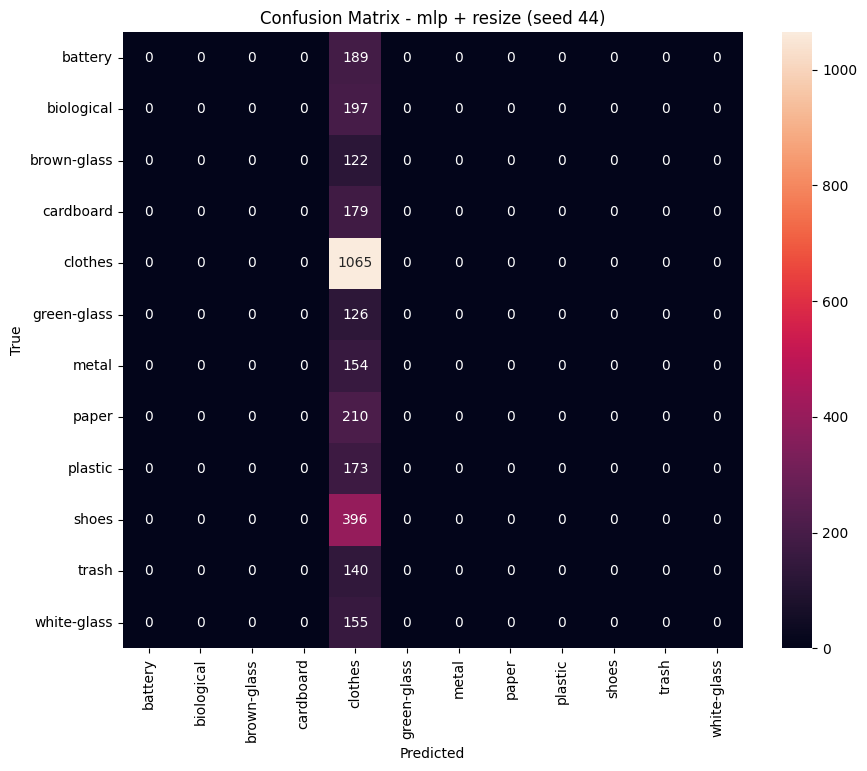


TREINANDO: Modelo=mlp, Pré-processamento=crop, Seed=42
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Resultados para mlp + crop (seed 42):
Acurácia: 0.3451
F1-score (macro): 0.0511
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       189
  biological       0.61      0.06      0.10       197
 brown-glass       0.00      0.00      0.00       122
   cardboard       0.00      0.00      0.00       179
     clothes       0.34      1.00      0.51      1065
 green-glass       0.00      0.00      0.00       126
       metal       0.00      0.00      0.00       154
       paper       0.00      0.00      0.00       210
     plastic       0.00      0.00      0.00       173
       shoes       0.00      0.00      0.00       396
       trash       0.00      0.00      0.00       140
 white-glass       0.00      0.00      0.00       155

    accuracy                           0.35      3106
   macro avg       0.08      0.09      0.05      3106
weighted avg 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


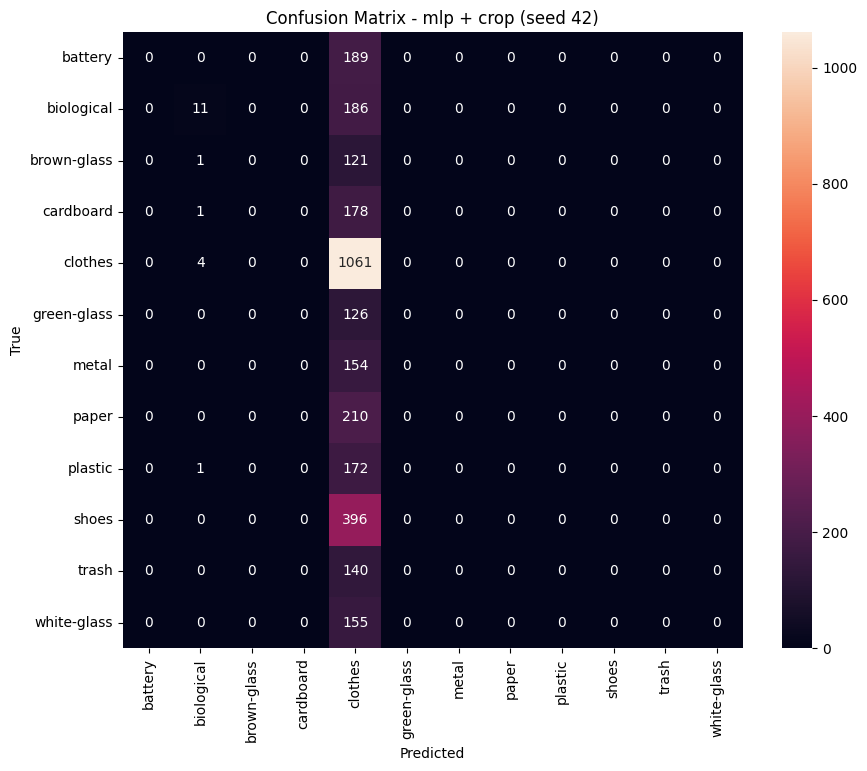


TREINANDO: Modelo=mlp, Pré-processamento=crop, Seed=43
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Resultados para mlp + crop (seed 43):
Acurácia: 0.3867
F1-score (macro): 0.1075
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       189
  biological       0.47      0.31      0.37       197
 brown-glass       0.00      0.00      0.00       122
   cardboard       0.00      0.00      0.00       179
     clothes       0.46      0.94      0.61      1065
 green-glass       0.00      0.00      0.00       126
       metal       0.00      0.00      0.00       154
       paper       0.12      0.04      0.06       210
     plastic       0.00      0.00      0.00       173
       shoes       0.18      0.34      0.24       396
       trash       0.00      0.00      0.00       140
 white-glass       0.00      0.00      0.00       155

    accuracy                           0.39      3106
   macro avg       0.10      0.14      0.11      3106
weighted avg 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


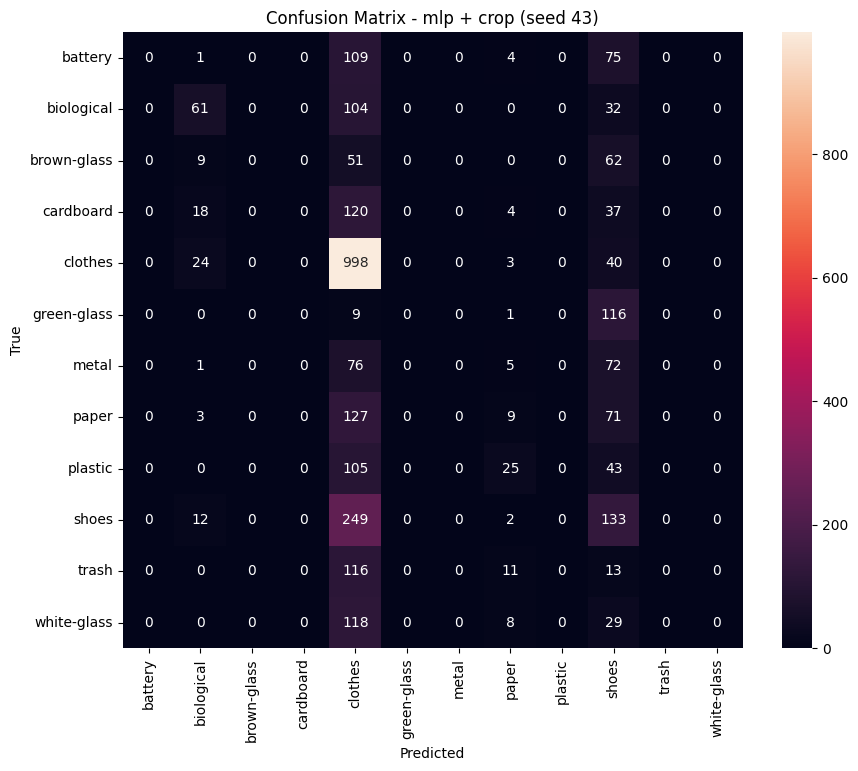


TREINANDO: Modelo=mlp, Pré-processamento=crop, Seed=44
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Resultados para mlp + crop (seed 44):
Acurácia: 0.3899
F1-score (macro): 0.1017
              precision    recall  f1-score   support

     battery       0.00      0.00      0.00       189
  biological       0.53      0.20      0.29       197
 brown-glass       0.00      0.00      0.00       122
   cardboard       0.00      0.00      0.00       179
     clothes       0.48      0.91      0.63      1065
 green-glass       0.00      0.00      0.00       126
       metal       0.00      0.00      0.00       154
       paper       0.05      0.00      0.01       210
     plastic       0.00      0.00      0.00       173
       shoes       0.20      0.51      0.29       396
       trash       0.00      0.00      0.00       140
 white-glass       0.00      0.00      0.00       155

    accuracy                           0.39      3106
   macro avg       0.10      0.14      0.10      3106
weighted avg 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


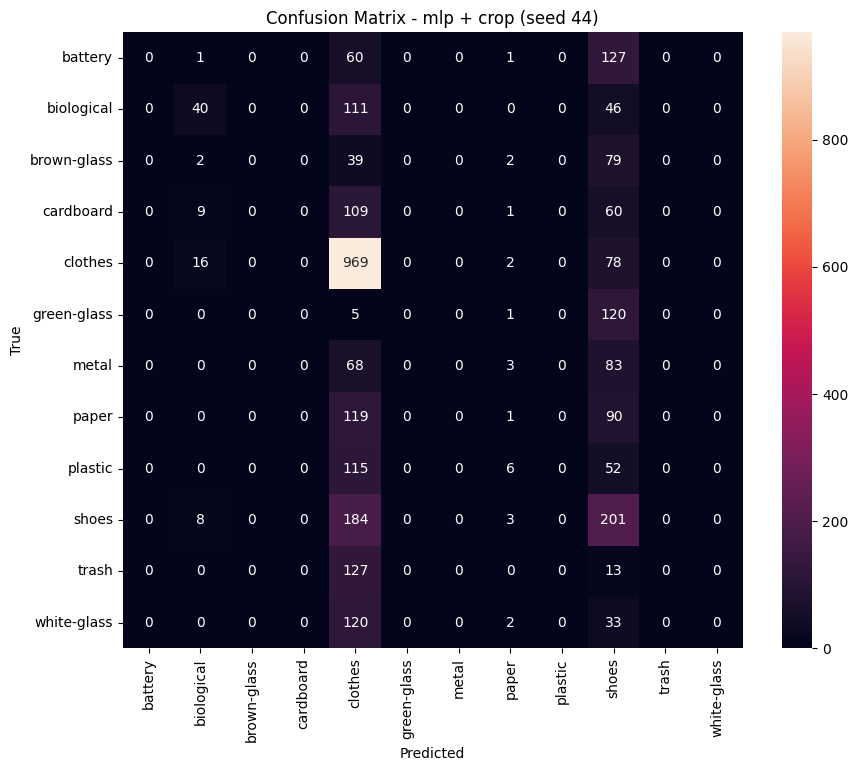


--- TODOS OS EXPERIMENTOS FORAM CONCLUÍDOS ---

Tabela Final de Resultados:
   model preprocess  seed  test_accuracy  f1_macro
0    cnn     resize    42       0.729234  0.670714
1    cnn     resize    43       0.731165  0.671886
2    cnn     resize    44       0.743400  0.684771
3    cnn       crop    42       0.455892  0.242350
4    cnn       crop    43       0.476175  0.281961
5    cnn       crop    44       0.456536  0.235567
6    mlp     resize    42       0.449453  0.237225
7    mlp     resize    43       0.446233  0.209177
8    mlp     resize    44       0.342885  0.042556
9    mlp       crop    42       0.345138  0.051107
10   mlp       crop    43       0.386671  0.107541
11   mlp       crop    44       0.389891  0.101697


In [14]:
import pandas as pd

all_results = []
all_results.append(res[3])

model_types = ["cnn", "mlp"]
preprocess_types = ["resize", "crop"]

print("--- INICIANDO BATERIA COMPLETA DE EXPERIMENTOS ---")

for model_name in model_types:
    for preprocess in preprocess_types:
        for seed in SEEDS:
            # Pula o experimento que já foi feito
            if model_name == "cnn" and preprocess == "resize" and seed == 42:
                print("PULANDO: Modelo=cnn, Pré-processamento=resize, Seed=42 (já executado)")
                continue

            print(f"\nTREINANDO: Modelo={model_name}, Pré-processamento={preprocess}, Seed={seed}")

            if model_name == "cnn":
                train_data, test_data = (train_ds_resize, test_ds_resize) if preprocess == "resize" else (train_ds_crop, test_ds_crop)
            else: # mlp
                train_data, test_data = train_ds_mlp, test_ds_mlp

            _, _, _, result_dict = train_and_evaluate(
                model_name=model_name, preprocess=preprocess, seed=seed,
                epochs=EPOCHS, class_names=class_names,
                train_ds=train_data, test_ds=test_data
            )
            all_results.append(result_dict)

print("\n--- TODOS OS EXPERIMENTOS FORAM CONCLUÍDOS ---")

results_df = pd.DataFrame(all_results)
print("\nTabela Final de Resultados:")
print(results_df[['model', 'preprocess', 'seed', 'test_accuracy', 'f1_macro']])

In [15]:
# O script é executado após o loop de testes e antes do código de plotagem.

print("--- Correção da lista de resultados ---")

# Adiciona o resultado do treino manual (variável 'res') à lista de resultados.
# A finalidade é incluir o experimento que foi omitido durante o loop principal.
if len(all_results) == 11: # A adição ocorre apenas se o resultado estiver ausente.
    all_results.append(res)
    print("Resultado do treino (cnn, resize, seed=42) foi adicionado.")

# O DataFrame é recriado com a lista completa de 12 resultados.
results_df = pd.DataFrame(all_results)

# A composição final do DataFrame é verificada.
print("\nDataFrame final completo:")
print(results_df[['model', 'preprocess', 'seed', 'test_accuracy']])

--- Correção da lista de resultados ---

DataFrame final completo:
   model preprocess  seed  test_accuracy
0    cnn     resize    42       0.729234
1    cnn     resize    43       0.731165
2    cnn     resize    44       0.743400
3    cnn       crop    42       0.455892
4    cnn       crop    43       0.476175
5    cnn       crop    44       0.456536
6    mlp     resize    42       0.449453
7    mlp     resize    43       0.446233
8    mlp     resize    44       0.342885
9    mlp       crop    42       0.345138
10   mlp       crop    43       0.386671
11   mlp       crop    44       0.389891


In [16]:
import matplotlib.pyplot as plt
import os # Necessário para criar a pasta de figuras

def plot_history(history_dict, save_path="figures/train_val_curve.png"):
    """
    Plota as curvas de acurácia e perda (Loss) a partir de um dicionário de histórico.

    Argumentos:
        history_dict: O dicionário history.history (ex: history_cnn.history).
        save_path: O caminho onde a figura será salva.
    """
    plt.figure(figsize=(12, 5))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)

    # Verifica se as chaves existem no dicionário
    if 'accuracy' in history_dict and 'val_accuracy' in history_dict:
        plt.plot(history_dict['accuracy'], label="Treino")
        plt.plot(history_dict['val_accuracy'], label="Validação")
        plt.title("Acurácia")
        plt.xlabel("Épocas")
    else:
        plt.text(0.5, 0.5, "Dados de Acurácia Ausentes", ha='center', va='center')
        plt.title("Acurácia (Dados Ausentes)")

    plt.legend()
    plt.grid(True)

    # Gráfico de Perda
    plt.subplot(1, 2, 2)

    # Verifica se as chaves existem no dicionário
    if 'loss' in history_dict and 'val_loss' in history_dict:
        plt.plot(history_dict['loss'], label="Treino")
        plt.plot(history_dict['val_loss'], label="Validação")
        plt.title("Perda (Loss)")
        plt.xlabel("Épocas")
    else:
        plt.text(0.5, 0.5, "Dados de Perda Ausentes", ha='center', va='center')
        plt.title("Perda (Dados Ausentes)")

    plt.legend()
    plt.grid(True)

    # 1. Cria a pasta 'figures' se ela não existir
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 2. Salva a figura
    plt.savefig(save_path)
    plt.show()


--- Rodada 1 (Seed: 42) ---
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultados para mlp + normalizado (seed 42):
Acurácia: 0.4092
F1-score (macro): 0.1351
              precision    recall  f1-score   support

    Classe 0       0.00      0.00      0.00       189
    Classe 1       0.18      0.58      0.27       197
    Classe 2       0.00      0.00      0.00       122
    Classe 3       0.00      0.00      0.00       179
    Classe 4       0.64      0.86      0.73      1065
    Classe 5       0.00      0.00      0.00       126
    Classe 6       0.00      0.00      0.00       154
    Classe 7       0.18      0.42      0.26       210
    Classe 8       0.00      0.00      0.00       173
    Classe 9       0.28      0.38      0.32       396
   Classe 10       0.00      0.00      0.00       140
   Classe 11       0.27      0.02      0.04       155

    accuracy                           0.41      3106
   macro avg       0.13      0.19      0.14      3106
weighted avg       0.29      0.41

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


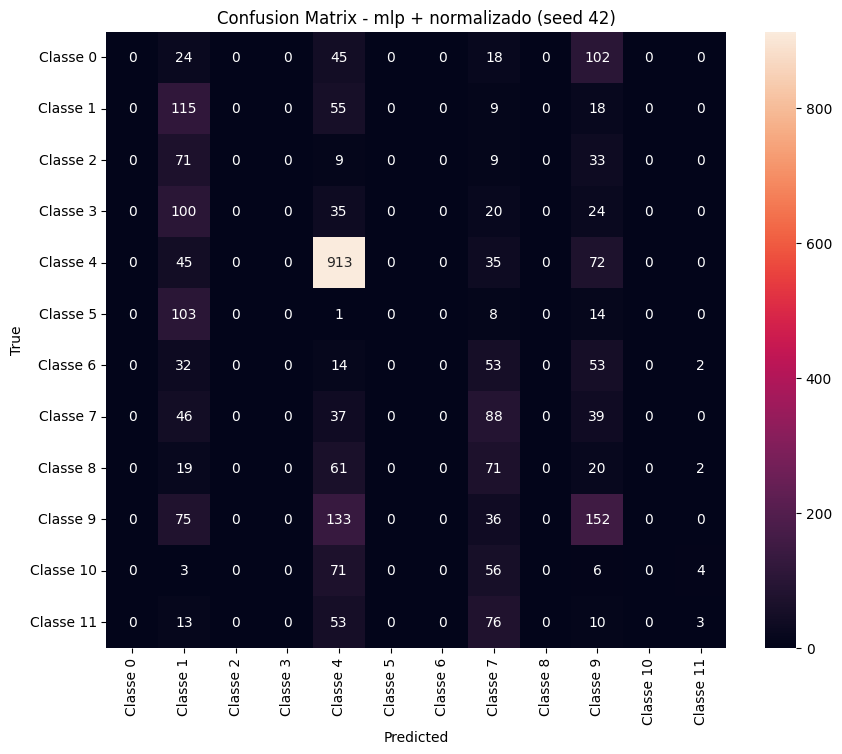

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Resultados para cnn + normalizado (seed 42):
Acurácia: 0.7231
F1-score (macro): 0.6567
              precision    recall  f1-score   support

    Classe 0       0.63      0.68      0.65       189
    Classe 1       0.74      0.81      0.77       197
    Classe 2       0.68      0.70      0.69       122
    Classe 3       0.75      0.79      0.77       179
    Classe 4       0.87      0.90      0.88      1065
    Classe 5       0.79      0.96      0.87       126
    Classe 6       0.47      0.34      0.39       154
    Classe 7       0.65      0.73      0.69       210
    Classe 8       0.57      0.39      0.47       173
    Classe 9       0.57      0.56      0.56       396
   Classe 10       0.59      0.66      0.62       140
   Classe 11       0.61      0.43      0.51       155

    accuracy                           0.72      3106
   macro avg       0.66      0.66      0.66      3106
weighted avg       0.71      0.72      0.72      3106



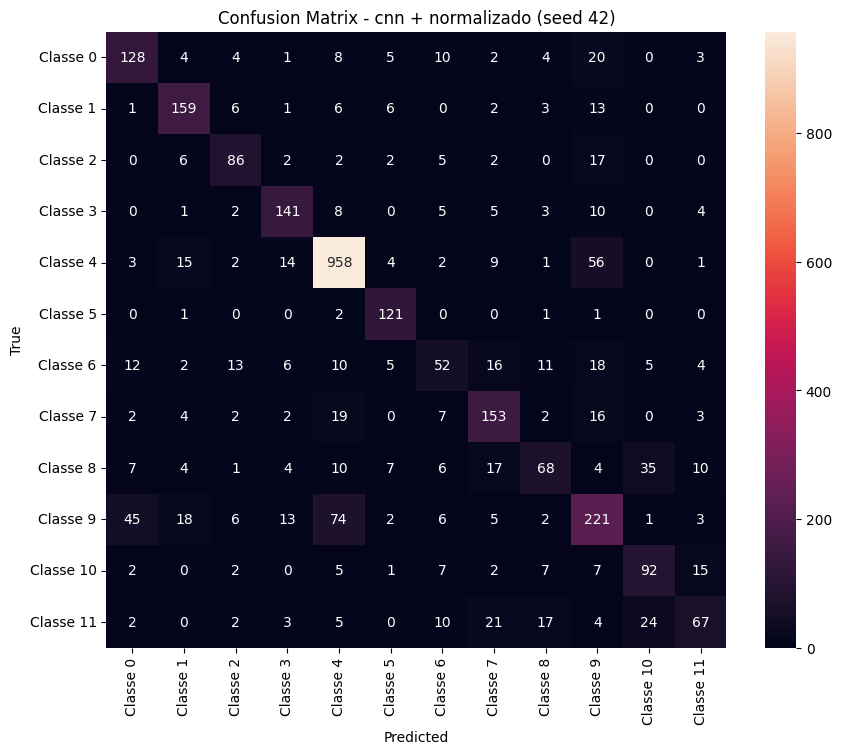


--- Rodada 2 (Seed: 43) ---
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultados para mlp + normalizado (seed 43):
Acurácia: 0.4668
F1-score (macro): 0.2501
              precision    recall  f1-score   support

    Classe 0       0.00      0.00      0.00       189
    Classe 1       0.49      0.38      0.43       197
    Classe 2       0.00      0.00      0.00       122
    Classe 3       0.36      0.26      0.30       179
    Classe 4       0.65      0.88      0.75      1065
    Classe 5       0.41      0.75      0.53       126
    Classe 6       0.00      0.00      0.00       154
    Classe 7       0.20      0.22      0.21       210
    Classe 8       0.30      0.06      0.10       173
    Classe 9       0.26      0.45      0.33       396
   Classe 10       0.25      0.01      0.01       140
   Classe 11       0.30      0.38      0.34       155

    accuracy                           0.47      3106
   macro avg       0.27      0.28      0.25      3106
weighted avg       0.38      0.47

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


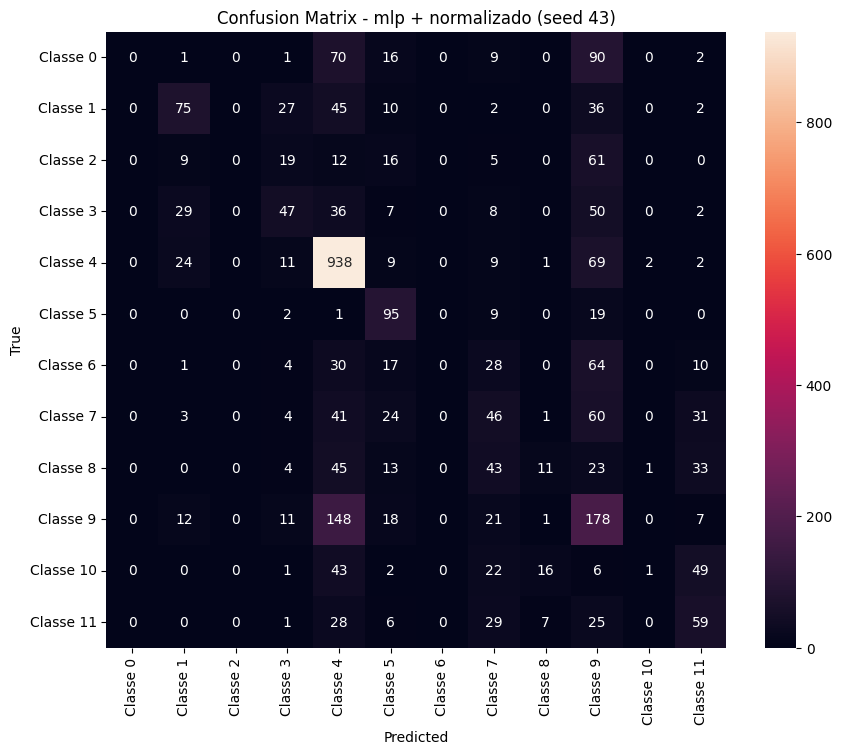

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Resultados para cnn + normalizado (seed 43):
Acurácia: 0.7408
F1-score (macro): 0.6780
              precision    recall  f1-score   support

    Classe 0       0.77      0.56      0.65       189
    Classe 1       0.67      0.82      0.74       197
    Classe 2       0.74      0.74      0.74       122
    Classe 3       0.80      0.74      0.77       179
    Classe 4       0.85      0.91      0.88      1065
    Classe 5       0.84      0.87      0.86       126
    Classe 6       0.55      0.38      0.45       154
    Classe 7       0.72      0.72      0.72       210
    Classe 8       0.56      0.51      0.53       173
    Classe 9       0.60      0.70      0.64       396
   Classe 10       0.64      0.58      0.61       140
   Classe 11       0.69      0.46      0.55       155

    accuracy                           0.74      3106
   macro avg       0.70      0.67      0.68      3106
weighted avg       0.74      0.74      0.73      3106



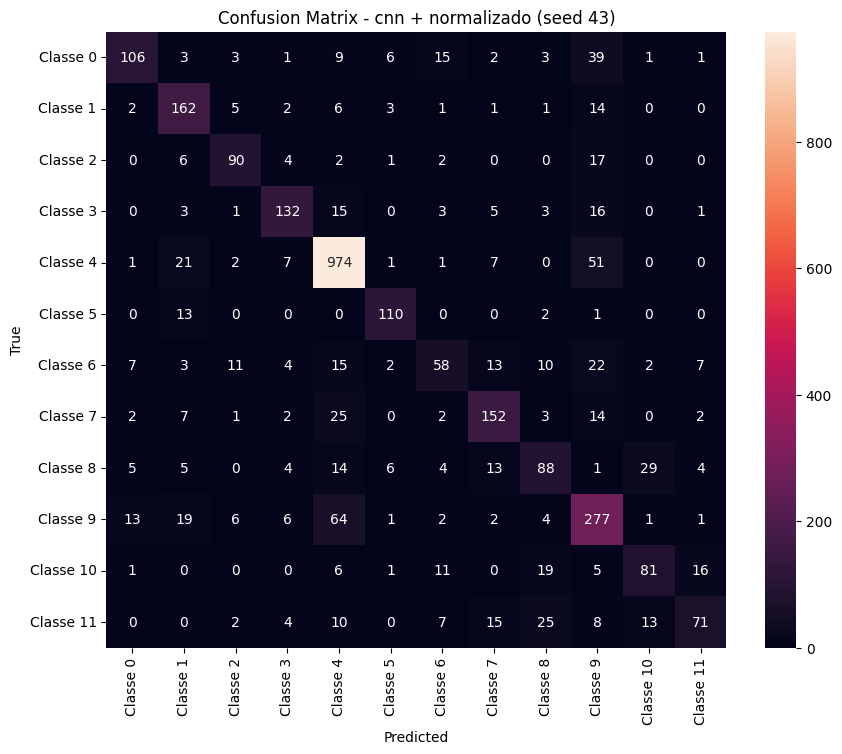


--- Rodada 3 (Seed: 44) ---
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultados para mlp + normalizado (seed 44):
Acurácia: 0.3925
F1-score (macro): 0.1042
              precision    recall  f1-score   support

    Classe 0       0.00      0.00      0.00       189
    Classe 1       0.53      0.21      0.30       197
    Classe 2       0.00      0.00      0.00       122
    Classe 3       0.00      0.00      0.00       179
    Classe 4       0.49      0.91      0.64      1065
    Classe 5       0.00      0.00      0.00       126
    Classe 6       0.00      0.00      0.00       154
    Classe 7       0.14      0.01      0.02       210
    Classe 8       0.00      0.00      0.00       173
    Classe 9       0.20      0.53      0.29       396
   Classe 10       0.00      0.00      0.00       140
   Classe 11       0.00      0.00      0.00       155

    accuracy                           0.39      3106
   macro avg       0.11      0.14      0.10      3106
weighted avg       0.24      0.39

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


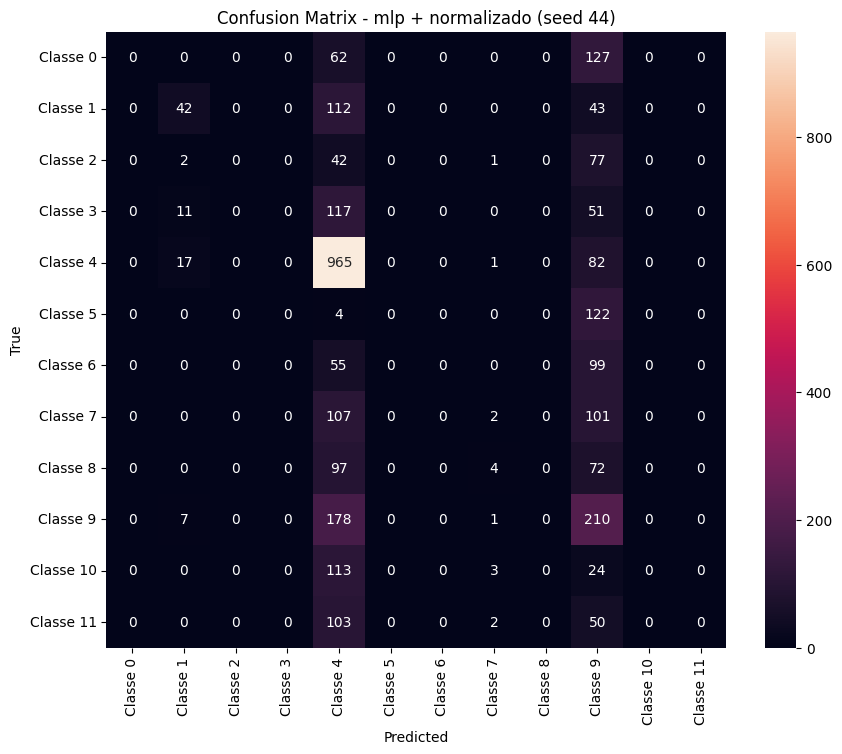

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Resultados para cnn + normalizado (seed 44):
Acurácia: 0.7283
F1-score (macro): 0.6620
              precision    recall  f1-score   support

    Classe 0       0.75      0.50      0.60       189
    Classe 1       0.70      0.82      0.76       197
    Classe 2       0.70      0.73      0.71       122
    Classe 3       0.67      0.84      0.74       179
    Classe 4       0.87      0.91      0.89      1065
    Classe 5       0.83      0.93      0.88       126
    Classe 6       0.51      0.34      0.41       154
    Classe 7       0.72      0.72      0.72       210
    Classe 8       0.59      0.46      0.52       173
    Classe 9       0.57      0.60      0.59       396
   Classe 10       0.62      0.59      0.60       140
   Classe 11       0.57      0.52      0.54       155

    accuracy                           0.73      3106
   macro avg       0.67      0.66      0.66      3106
weighted avg       0.72      0.73      0.72      3106



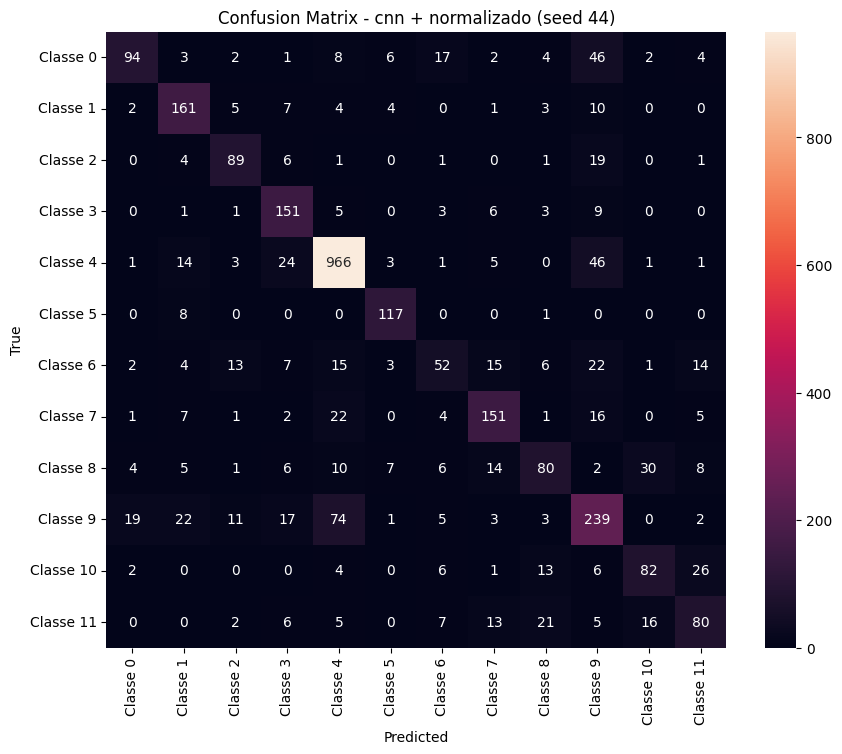


--- Resultados Finais (Média ± Desvio Padrão) ---
MLP: Acurácia = 0.423 ± 0.032, F1 = 0.163 ± 0.063
CNN: Acurácia = 0.731 ± 0.007, F1 = 0.666 ± 0.009


In [17]:
import numpy as np

num_classes = 12
preprocess = "normalizado"
class_names = [f'Classe {i}' for i in range(num_classes)]

train_ds_cnn = train_ds_resize
test_ds_cnn = test_ds_resize

results = {"MLP": [], "CNN": []}

for i, seed in enumerate(SEEDS):
    print(f"\n--- Rodada {i+1} (Seed: {seed}) ---")

    # Recebe 4 valores: history, acc, f1 e o dicionário completo
    history_mlp, acc_mlp, f1_mlp, res_dict_mlp = train_and_evaluate(
        "mlp", preprocess, seed, EPOCHS, class_names, train_ds_mlp, test_ds_mlp
    )
    results["MLP"].append([acc_mlp, f1_mlp])

    # Recebe 4 valores: history, acc, f1 e o dicionário completo
    history_cnn, acc_cnn, f1_cnn, res_dict_cnn = train_and_evaluate(
        "cnn", preprocess, seed, EPOCHS, class_names, train_ds_cnn, test_ds_cnn
    )
    results["CNN"].append([acc_cnn, f1_cnn])

print("\n--- Resultados Finais (Média ± Desvio Padrão) ---")

for model in results:
    all_metrics = np.array(results[model])

    mean_acc = np.mean(all_metrics[:, 0])
    std_acc = np.std(all_metrics[:, 0])
    mean_f1 = np.mean(all_metrics[:, 1])
    std_f1 = np.std(all_metrics[:, 1])

    print(f"{model}: Acurácia = {mean_acc:.3f} ± {std_acc:.3f}, F1 = {mean_f1:.3f} ± {std_f1:.3f}")

### Configurando repositório